In [49]:
import pandas as pd
import psycopg2
import dotenv
import os
import matplotlib.pyplot as plt
from mplsoccer import Pitch

dotenv.load_dotenv()

PG_PASSWORD = os.getenv("PG_PASSWORD")
PG_USER = os.getenv("PG_USER")
PG_HOST = os.getenv("PG_HOST")
PG_PORT = os.getenv("PG_PORT")
PG_DATABASE = os.getenv("PG_DB")

# Database connection parameters
import psycopg2
import os

conn = psycopg2.connect(
    host=PG_HOST,
    database=PG_DATABASE,
    user=PG_USER,
    password=PG_PASSWORD,
    port=PG_PORT,
    sslmode="require",
)

In [73]:
team = "ecj1gmc7pqcjo4sc9hvghj5u3"

In [74]:
query = f"""
    SELECT match_id
    FROM matches
    WHERE home_team_id = '{team}' 
        OR away_team_id = '{team}'
"""

match_ids = pd.read_sql_query(query, conn)
match_ids = match_ids["match_id"].tolist()

print(len(match_ids))
match_ids

18


['5ow2wa823rjft38oh48b4ror8',
 '5vxo6e7c495zmi951vfdf8vtg',
 '5y7o12321gsyhahz2gn9k70gk',
 '633kfo3pvp46mgpidjadmzg2c',
 '66gwllyydpsz7dx3yxkxq9ixg',
 '68eiweirqknjn592234u1xlw4',
 '6bfrz2jq6km4wkxuqtscmzgus',
 '6ddnhqps3jpvpthkwmpo00h04',
 '6gfytd52ib44k8sm0pc8lohzo',
 '6jlrinuzb0udhcixas2e9fh90',
 '6n8z4gyo5m3xo8sz52sbmuec4',
 '6sfzz7fdc8ihyiwgsvbo09s0k',
 '6t7akwoa8n6jp6buko1cbwges',
 '6y80kic6abtlkzmkr4oiejkt0',
 '6zrmzdgg5dvdmghjcyp698pw4',
 '74fg5ak3m9a9n8u7ip5u56t5g',
 '75xyj0hlct5wqv6uamxf8c1ec',
 '78nndczlbj2214zhtbfahs2s4']

In [75]:
query = f"""
    SELECT player_id, 
           player_name
    FROM players
    WHERE team_id = '{team}'
"""

players = pd.read_sql_query(query, conn)
player_ids = players["player_id"].tolist()
player_names = dict(zip(players["player_id"], players["player_name"]))

len(players)

31

In [76]:
query = f"""
    SELECT period_id, 
           timestamp, 
           ball_owning_team,
           player_id,
           match_id
    FROM matchevents
    WHERE match_id IN {tuple(match_ids)}
    ORDER BY match_id, period_id, timestamp
"""

df = pd.read_sql_query(query, conn)
df["timestamp"] = pd.to_timedelta(df["timestamp"])
dfs = [df[df["match_id"] == match_id] for match_id in match_ids]
dfs = [df_match for df_match in dfs if not df_match.empty]

if len(dfs) < len(match_ids):
    match_ids = [df_match["match_id"].values[0] for df_match in dfs]

len(dfs)

16

In [82]:
query = f"""
    SELECT timestamp,
           period_id,
           player_id,
           x,
           y,
           game_id
    FROM player_tracking
    WHERE game_id IN {tuple(match_ids)} AND player_id != 'ball' 
        AND player_id IN {tuple(player_ids)}
    ORDER BY game_id, period_id, timestamp
"""

df = pd.read_sql_query(query, conn)
df["timestamp"] = pd.to_timedelta(df["timestamp"])
player_trackings = [df[df["game_id"] == game_id] for game_id in match_ids]
player_trackings = [df_match for df_match in player_trackings if not df_match.empty]

if len(player_trackings) < len(match_ids):
    match_ids = [df_match["game_id"].values[0] for df_match in player_trackings]
    if len(player_trackings) < len(dfs):
        dfs = [df_match for df_match in dfs if df_match["match_id"].values[0] in match_ids]

print(len(player_trackings))
print(len(dfs))

15
15


In [77]:
player_stamp = []

for df in dfs:
    for i in range(len(df)):
        if i == 0:
            continue

        if df["ball_owning_team"].iloc[i-1] != team and df["ball_owning_team"].iloc[i] == team:

            start_time = df["timestamp"].iloc[i]
            possession = True

            for j in range(i, len(df)):
                if df["timestamp"].iloc[j]-start_time >= pd.Timedelta(seconds=5):
                    break

                if df["ball_owning_team"].iloc[j] != team:
                    possession = False
                    break

            if possession and df["player_id"].iloc[i] in player_ids:
                player_stamp.append((df["match_id"].iloc[i], 
                                     df["player_id"].iloc[i], 
                                     df["timestamp"].iloc[i], 
                                     df["period_id"].iloc[i]))

len(player_stamp)

1393

In [79]:
query = f"""
    SELECT period_id,
           player_id,
           x,
           timestamp,
           game_id
    FROM player_tracking
    WHERE game_id IN {tuple(match_ids)} 
        AND player_id != 'ball'
        AND timestamp <= '00:00:02'
        AND player_id IN {tuple(player_ids)}
    ORDER BY game_id, period_id, timestamp
"""
df = pd.read_sql_query(query, conn)
df["timestamp"] = pd.to_timedelta(df["timestamp"])

atk_directions = (
    df.groupby(["game_id", "period_id"])["x"]
    .mean()
    .apply(lambda avg_x: 1 if avg_x < 50 else -1)
    .reset_index()
)
atk_directions = {
    (game_id, period_id): direction for game_id, period_id, direction in atk_directions.itertuples(index=False, name=None)
}

len(atk_directions)


30

In [80]:
vectors = []

for df in player_trackings:
    for match_id, player_id, timestamp, period_id in player_stamp:
        if df["game_id"].iloc[0] != match_id:
            continue

        loop_df = df[df["player_id"] == player_id]
        loop_df = loop_df[loop_df["period_id"] == period_id]

        rounded_value = timestamp.floor("s")

        start_x, start_y, end_x, end_y = None, None, None, None

        for i in range(len(loop_df)):
            rounded_time = loop_df["timestamp"].iloc[i].floor("s")

            if rounded_time == rounded_value:
                start_x = loop_df["x"].iloc[i]
                start_y = loop_df["y"].iloc[i]
            else:
                end_x = loop_df["x"].iloc[i]
                end_y = loop_df["y"].iloc[i]
                if rounded_time >= rounded_value + pd.Timedelta(seconds=5):
                    break

        if start_x and start_y and end_x and end_y:
            vectors.append((start_x, start_y, end_x, end_y, period_id, player_id, match_id))

len(vectors)

1313

/tmp/ipykernel_43859/3694482770.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  aligned_vectors.append((float(start_x), float(start_y), float(end_x), float(end_y), period_id, player_id))


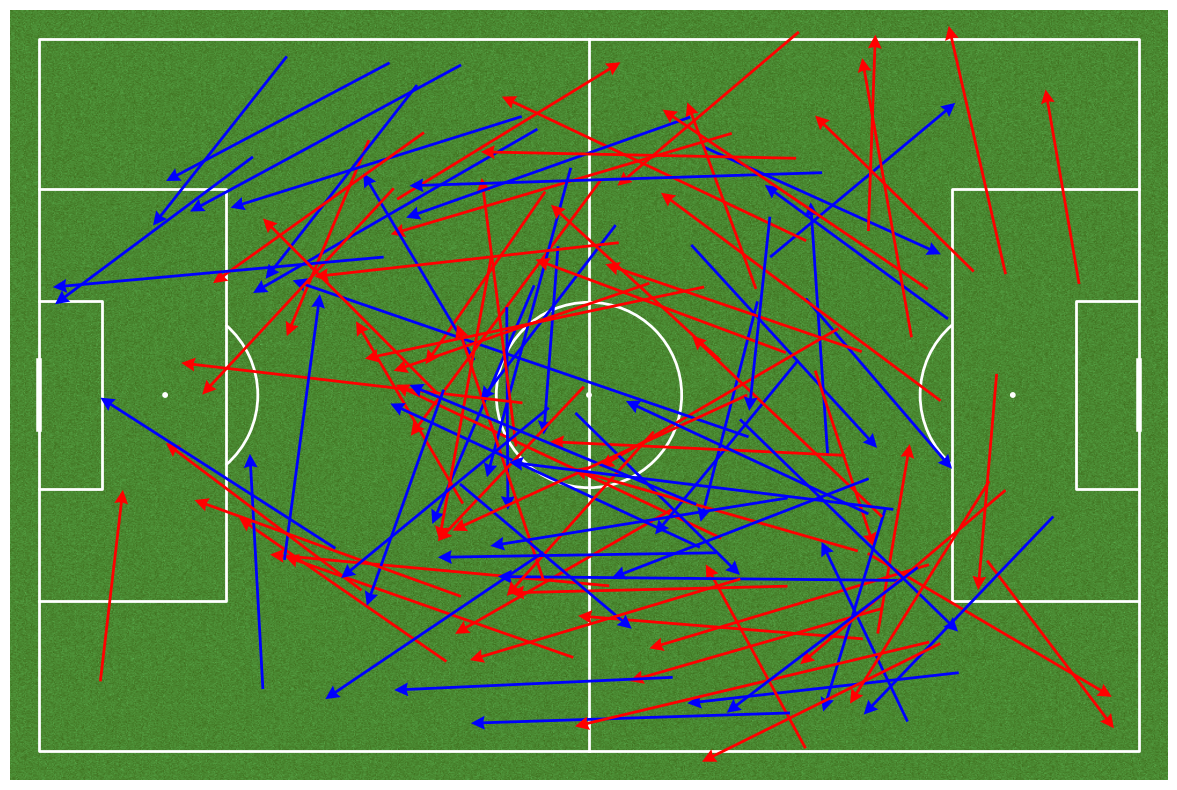

In [81]:
pitch = Pitch(pitch_color="grass", line_color="white", pitch_type="opta", pitch_length=105, pitch_width=68)

aligned_vectors = []

for start_x, start_y, end_x, end_y, period_id, player_id, match_id in vectors:
    direction = atk_directions.get((match_id, period_id))
    
    if direction == 1:
        start_x, start_y = pitch.flip_side(start_x, start_y, True)
        end_x, end_y = pitch.flip_side(end_x, end_y, True)

    aligned_vectors.append((float(start_x), float(start_y), float(end_x), float(end_y), period_id, player_id))

fig, ax = pitch.draw(figsize=(12, 8))
for x, y, ex, ey, period_id, player_id in aligned_vectors:
    color = "blue" if period_id == 1 else "red"
    distance = ((ex - x) ** 2 + (ey - y) ** 2) ** 0.5

    if distance > 25:
        pitch.arrows(x, y, ex, ey, color=color, width=2, ax=ax, headwidth=5, headlength=5)

plt.tight_layout()
plt.show()